# trialSim.py Random Weight Testing

This code added and tested a randomizer for the excitatory weights at mossy fiber to granule cells (and MF-GoC), adding a randomizer for inhibitory is easily implimented.

In [1]:
from brian2 import *
from matplotlib import *
import numpy as np
import random
from fractions import Fraction
import pandas as pd
import time

%matplotlib inline

## Parameters

#### Modified Parameter Vars used during testing

In [2]:
#I would suggest renaming the vars to match brian2 f() args that go from Source to Target. 
random_MF_weight_gamma = True 

MF_GrC_gamma_shape = 1
MF_GrC_gamma_scale = 1
MF_GoC_gamma_shape = 1
MF_GoC_gamma_scale = 1

fixed_GrC_mf_w_e = 0.65 * nS 
fixed_GoC_mf_w_e = 0.35  * nS 
# fixed_mf_GrC_w_e = 0.65 * nS #renamed vars
# fixed_mf_GoC_w_e = 0.35  * nS #renamed vars

# TODO: Future Code after added lines into random weight section
# fixed_GoC_GrC_w_i = 0.08 * nS #TODO(trf): use after writing random inhibitory weight code

#### Fixed Parameter Vars used during testing

In [3]:
seed(451)
# Parameters 
##############
Condition = 'Control' # Control, GABAzine, ACh
ntrial = 1 #number of trials in simulation
runtime = 2000
#random_MF_weight_gamma = False #For Final Code

#TODO(?): rename the following vars to match var naming (Target, Source)?
# MF_GrC_gamma_shape = 1 #For Final Code
# MF_GrC_gamma_scale = 1 #For Final Code
# MF_GoC_gamma_shape = 1 #For Final Code
# MF_GoC_gamma_scale = 1 

# Cell numbers to reproduce functionally relevant 100um^3 cube of granular layer
nmf  =  315                 # Mossy fibers
nGrC = 4096                 # Granule cells
nGoC =   27                 # Golgi cells

# Convergence ratios of connections (to determine connection probabilities)
conv_GrC_M   =   4          #  mf -> GrC synapses
conv_GoC_M   =  50          #  mf -> GoC synapses
conv_GoC_GrC = 100          # GrC -> GoC synapses
conv_GrC_GoC =   4          # Goc -> GrC synapses

# Leak conductance
g_l_GrC   = 0.4   * nS
g_t_GrC   = 0.4   * nS

g_l_GoC   = 3.    * nS

# Reversal potential (leak, excitatory, inhibitory)
E_l_GrC   = -75   * mV
E_e_GrC   =   0   * mV
E_i_GrC   = -75   * mV

E_l_GoC   = -50   * mV
E_e_GoC   =   0   * mV
E_i_GoC   = -75   * mV

# Membrane capacitance
C_m_GrC   =  3.1  * pF
C_m_GoC   = 60.   * pF

# TODO Use rise and decay times and add dyanmics to neuron Equations
tau_e_decay_GrC = 6.0 * ms
tau_e_decay_GoC = 3.0 * ms

tau_i_decay_GrC = 15.0 * ms

# Absolute refractory period
tau_r = 2 * ms

# Spiking threshold
V_th_GrC   = -55 * mV
V_th_GoC   = -50 * mV

# Resting potential
V_r_GrC    = -75 * mV
V_r_GoC    = -55 * mV

# Golgi cell reset potential
V_reset_GoC = -60 * mV

# Synaptic weights
# w_e_GrC = 0.65 * nS #delete for final code
w_i_GrC = 0.08 * nS

# w_e_GoC_M = 0.35  * nS #delete for final code
w_e_GoC_GrC = 0.0 * nS

# Stochastic fluctuating excitatory current
sigma_n_GoC = 0.01 * nS
sigma_n_GrC = 0.03 * nS

tau_n   = 20 * ms

## Brian2 Code

In [4]:
### Equations 
#############

GrC_eqs = '''
dv/dt   = (g_l*(E_l-v) + (g_e+g_n)*(E_e-v) + (g_i+g_t)*(E_i-v))/C_m : volt (unless refractory)
dg_n/dt = (-g_n + sigma_n_GrC * sqrt(tau_n) * xi)/tau_n : siemens
dg_e/dt = -g_e/tau_e : siemens
dg_i/dt = -g_i/tau_i : siemens
'''

GoC_eqs = '''
dv/dt   = (g_l*(E_l-v) + (g_e+g_n)*(E_e-v))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens
dg_n/dt = (-g_n + sigma_n_GoC * sqrt(tau_n) * xi)/tau_n : siemens
'''
### Mossy fiber input 
#####################

stim_times = [1010, 1020, 1030]            # Mossy fiber stimulation times
nstim      = len(stim_times)
mf_indices = np.arange(nmf)
n_active   = round(nmf/20)           # Fraction of mfs active at each stimulation

# Randomly select a subset of mossy fibers to spike at each stimulation
# If you want a different subset of mossy fibers at each stimulation, move
# the declaration of [active_indices] into the loop over stim_times
random.seed(a=451)
active_indices = [mf_indices[i] for i in sorted(random.sample(range(len(mf_indices)),n_active))]
indices    = []
times      = []
for j in range(nstim):
    indices.extend(active_indices)
    times.extend([stim_times[j]]*len(active_indices))
times    = times * ms
mf_input = SpikeGeneratorGroup(nmf, indices, times)

### Neuron populations 
######################
GrC = NeuronGroup(nGrC,
                  Equations(GrC_eqs,
                            g_l   = g_l_GrC,
                            g_t   = g_t_GrC,
                            E_l   = E_l_GrC,
                            E_e   = E_e_GrC,
                            E_i   = E_i_GrC,
                            C_m   = C_m_GrC,
                            tau_e = tau_e_decay_GrC,
                            tau_i = tau_i_decay_GrC),
                  threshold  = 'v > V_th_GrC',
                  reset      = 'v = V_r_GrC',
                  refractory = 'tau_r',
                  method     = 'euler')
GrC.v   = V_r_GrC

GoC = NeuronGroup(nGoC,
                  Equations(GoC_eqs,
                            g_l = g_l_GoC,
                            E_l = E_l_GoC,
                            E_e = E_e_GoC,
                            E_i = E_i_GoC,
                            C_m = C_m_GoC,
                            tau_e = tau_e_decay_GoC),
                  threshold  = 'v > V_th_GoC',
                  reset      = 'v = V_reset_GoC',
                  refractory = 'tau_r',
                  method     = 'euler')
GoC.v = V_r_GoC

### Connect neurons 
###################

# Mossy fiber onto GrCs
GrC_M = Synapses(mf_input, GrC, 
                 model='w_e_GrC : siemens',
                 on_pre = 'g_e += w_e_GrC')
#GrC_M = Synapses(mf_input, GrC,
#                 on_pre = 'g_e += w_e_GrC')
GrC_M.connect(p = conv_GrC_M/nmf)

# Mossy fiber onto GoCs
GoC_M = Synapses(mf_input, GoC,
                 model='w_e_GoC_M : siemens',
                 on_pre = 'g_e += w_e_GoC_M')
GoC_M.connect(p = conv_GoC_M/nmf)

# GrC onto GoCs
GoC_GrC = Synapses(GrC, GoC,
                   on_pre = 'g_e += w_e_GoC_GrC')
GoC_GrC.connect(p = conv_GoC_GrC/nGrC)

# GoC onto GrC (inhibitory)
GrC_GoC = Synapses(GoC, GrC,
# TODO: Future Code after added lines into random weight section
#                    model='w_i_GrC : siemens', 
                   on_pre = 'g_i += w_i_GrC',
                   delay  = tau_r)
GrC_GoC.connect(p = conv_GrC_GoC/nGoC)

### Random Weight Code 
######################
if random_MF_weight_gamma is True:
    #Store the random weight values generated during the simulation in a dict
    active_mf_GrC_weights = dict()
    active_mf_GoC_weights = dict()
    print("Randomizing Synaptic Weights using Gamma Distribution")
    
    #Fixed Testing var, delete this line after checking the Vm of GrC connected
    #       to Mossy Fibers# 20 vs 22. GrC connected to MF# 20 should be fixed, 
    #       while GrC connected to MF# 22 will float
    GrC_M.w_e_GrC[20,:] = 0 * nS #Code Testing Line, Delete for Final Code
    
    @network_operation(dt=runtime * ms, when='start')
    def update_input():
        for i in active_indices[1:]: #Code Testing exclude MF# 20 from the randomizer, delete after testing
#        for i in active_indices: #Use this line for Final Code
            temp_w_MF_GrC = np.random.gamma(MF_GrC_gamma_shape, 
                                            MF_GrC_gamma_scale) * nS
            temp_w_MF_GoC = np.random.gamma(MF_GoC_gamma_shape,
                                            MF_GoC_gamma_scale) * nS
            GrC_M.w_e_GrC[i, :] = temp_w_MF_GrC
            GoC_M.w_e_GoC_M[i, :] = temp_w_MF_GoC
            # fill in weight dictionary by mossy fiber number, add new mf key if non-existant
            if i in active_mf_GrC_weights.keys():
                active_mf_GrC_weights[i].append(temp_w_MF_GrC)
                active_mf_GoC_weights[i].append(temp_w_MF_GoC)
            else:
                active_mf_GrC_weights[i] = [temp_w_MF_GrC]
                active_mf_GoC_weights[i] = [temp_w_MF_GoC]
else:
    print("Using Fixed Synaptic Weights")
    for i in active_indices:
        GrC_M.w_e_GrC[i, :] = fixed_GrC_mf_w_e
        GoC_M.w_e_GoC_M[i, :] = fixed_GoC_mf_w_e
        
# TODO: Future Code after added lines into random weight section
#         GoC_M.w_i_GrC[i, :] = fixed_GoC_GrC_w_i #Future code 
        
### Simulation 
##############
M = SpikeMonitor(GrC)
state_GrC  = StateMonitor(GrC, 'v', record = True)
store('Control')

spikes = []
for trial in range(ntrial):
    print('Trial %d' % (trial+1))
    restore('Control')
    # Run simulation
    run(runtime * ms, report='stdout', report_period=1*second, 
        profile=True)
    
    # Save spike times for each simulation
    spike_trains = M.spike_trains()
    spikes.append(spike_trains)

Randomizing Synaptic Weights using Gamma Distribution
Trial 1
Starting simulation at t=0. s for a duration of 2. s
0.0001 (0%) simulated in 1s, estimated 6h 8m 27s remaining.
0.1499 (7%) simulated in 2s, estimated 26s remaining.
0.2906 (14%) simulated in 3s, estimated 18s remaining.
0.42250000000000004 (21%) simulated in 4s, estimated 15s remaining.
0.6229 (31%) simulated in 5s, estimated 11s remaining.
0.8193 (40%) simulated in 6s, estimated 9s remaining.
1.0169000000000001 (50%) simulated in 7s, estimated 7s remaining.
1.1482 (57%) simulated in 8s, estimated 6s remaining.
1.2664 (63%) simulated in 9s, estimated 5s remaining.
1.4598 (72%) simulated in 10s, estimated 4s remaining.
1.6243 (81%) simulated in 11s, estimated 3s remaining.
1.6513 (82%) simulated in 12s, estimated 3s remaining.
1.8036 (90%) simulated in 13s, estimated 1s remaining.
2.0 (100%) simulated in 14s


## Analysis Code

In [5]:
# Get spike times for all granule cells
df_spiketimes = pd.DataFrame(columns=['GrC', 'trial', 'Time_ms', 'Condition'])
for i, val in enumerate(spikes):
    temp_dict = {} 
    for key in val:
        temp_dict[key] = val[key]/second #strip brian2 units
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index') # this works
    temp_df['trial'] = i+1
    temp_df['GrC'] = temp_df.index
    temp_df = temp_df.melt(id_vars=['GrC', 'trial']) #convert from wide to long
    temp_df.drop(['variable'], axis=1, inplace=True) #cleanup vars due to melt
    temp_df['value'] = temp_df['value'].multiply(1000)
    temp_df.rename(index=str, columns={"value": "Time_ms"}, inplace=True)
    temp_df['Condition'] = 'control' 
    df_spiketimes = df_spiketimes.append(temp_df, ignore_index=True)

In [6]:
# Generate df with all Mossy Fiber - Granule Cell Pairs
df2 = pd.DataFrame({'MF':GrC_M.i[:],'GrC':GrC_M.j[:]})

### Random Weight Sanity Check Plots

In [7]:
# Get the GrCs that are active to all active MF (excluding MF#20), TESTING CODE
active_GrC_exclude_MF20 = df2.loc[df2['MF'].isin(active_indices[1:])].drop_duplicates(['GrC'])['GrC'].values

Looking the the membrane potential for granule cells connected to mossy fiber #20. This serves as a control, in which the random weight code above should cause the weight to be zero if random_MF_weight_gamma is True.

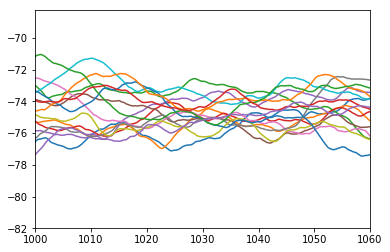

In [8]:
for cell in df2.loc[(df2['MF']==20) & ~(df2['GrC'].isin(active_GrC_exclude_MF20)), ]['GrC'].values[:15]:
    plot(state_GrC.t/ms, state_GrC.v[cell]/mV) 
    xlim(1000, 1060)
show()

Looking at the membrane potential for a subpopulation of GrC connected to mossy fiber# 22, these cells should receive randomized weights every simulation 'trial'

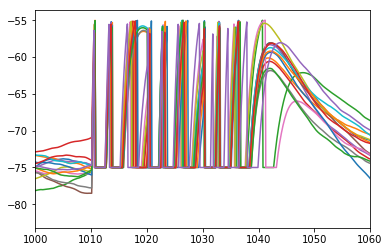

In [9]:
# Plot the first 15 GrC Vm that are connected to mossy fiber # 22
for cell in df2.loc[df2['MF']==22,]['GrC'].values[:15]:
    plot(state_GrC.t/ms, state_GrC.v[cell]/mV) 
    xlim(1000, 1060)
show()